<h4> <b> Youtube URL => Resúmen del contenido </b> </h4>

In [3]:
import openai
import pandas as pd
import time
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import ffmpeg
import os
from pytube import YouTube

openai.api_key = "sk-"

In [4]:
def green(text): return "\033[92m {}\033[00m".format(text)
def red(text): return "\033[91m {}\033[00m" .format(text)

Get Embeddings function

In [5]:
def get_embeddings(inputs):
   return [openai.Embedding.create(input = inputs, model="text-embedding-ada-002")['data'][i]['embedding'] for i in range(len(inputs))]

Descarga del archivo .mp3 a partir de la URL de Youtube

In [6]:
if os.path.exists("data/audio.mp3"): os.remove("data/audio.mp3")

url = input("Youtube URL: ")
yt = YouTube(url, use_oauth=True)

audio_stream = yt.streams.filter(only_audio=True).first()
audio_file = audio_stream.download()

(
    ffmpeg
    .input(audio_file)
    .output("data/audio.mp3")
    .run()
)

os.remove(audio_file)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Uso WHISPER para convertir el audio en texto y lo separo en oraciones

In [7]:
audio_file = open("data/audio.mp3", "rb")
transcript = openai.Audio.transcribe("whisper-1", audio_file)

sentences = transcript.text.split('.')

print(sentences[:5], "\n\nTotal sentences: " + str(len(sentences)))

['Hay algo que en los próximos años puede cambiar completamente el trabajo como lo conocemos hoy', ' Hay algo que en un futuro puede mejorar nuestra calidad de vida y salud sustancialmente', ' Hay algo que en un futuro puede mejorar nuestra calidad de vida y salud sustancialmente', ' Pero también hay algo que podría aniquilarnos como seres humanos', ' Esas tres cosas, trabajo, salud y muerte, en realidad dependen de una sola, de la inteligencia artificial'] 

Total sentences: 75


Creo el DataFrame y calculo los embeddings para cada oración

In [8]:
df = pd.DataFrame(sentences, columns = ['text'])

df = df[df.text != '']
df['embedding'] = get_embeddings(df.text.to_list())

df.to_csv("data/audio_embeddings.csv")
df.head()

,text,embedding
0,Hay algo que en los próximos años puede cambia...,"[-0.006441871635615826, -0.01371682807803154, ..."
1,Hay algo que en un futuro puede mejorar nuest...,"[0.010038762353360653, 0.011132853105664253, 0..."
2,Hay algo que en un futuro puede mejorar nuest...,"[0.010038762353360653, 0.011132853105664253, 0..."
3,Pero también hay algo que podría aniquilarnos...,"[-0.0005346755497157574, -0.011679735966026783..."
4,"Esas tres cosas, trabajo, salud y muerte, en ...","[0.0025878464803099632, 0.0009851186769083142,..."


Leo el .csv, utilizo KMEANS para generar clusters y TSNE para visualizar

In [9]:
df = pd.read_csv("data/audio_embeddings.csv")

Pido a <b> gpt </b> que categorice el transcripto del audio

In [10]:
all_sentences = df['text'].str.cat(sep = '.')

response = openai.ChatCompletion.create(

    model = "gpt-3.5-turbo",
    messages = [
        {'role': 'user', 'content': f'En cuantas secciones independientes dividirías el siguiente texto?: \n\n"""\n{ all_sentences }\n"""\n\n'}
    ],
    temperature = 0,
    max_tokens = 200,
    top_p = 1,
    frequency_penalty = 0,
    presence_penalty = 0,
)

print(response['choices'][0]['message']['content'])

Se podría dividir en las siguientes secciones:

1. Introducción: se presenta la idea de que la inteligencia artificial puede cambiar el trabajo, la salud y la muerte.
2. Definición de inteligencia artificial: se explica la definición propuesta por Alan Turing y cómo ha llevado a la replicación del comportamiento humano en distintos dominios.
3. Poder de la inteligencia artificial: se describen las características que hacen a las computadoras poderosas e inteligentes.
4. Debate sobre la seguridad de la inteligencia artificial: se presentan las posturas de Bill Gates, Elon Musk y Mark Zuckerberg sobre el desarrollo de la tecnología.
5. Aplicación de la inteligencia artificial en medicina: se explica cómo se ha desarrollado un sistema de inteligencia artificial para ayudar en el diagnóstico de enfermedades.
6. Avance de la inteligencia artificial en medicina: se presenta la posibilidad de que


Separo los <b> embeddings </b> utilizando KMEANS con k clusters, tomando la sugerencia de secciones dada previamente

In [11]:
n_clusters = 3
matrix = np.array(df.embedding.apply(eval).to_list())

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)

labels = kmeans.labels_
df['cluster'] = labels

/home/martin/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


TSNE

<b> perplexity </b> indica como balancear la atención entre aspectos locales y globales de los datos

In [12]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

Plot de la transformación

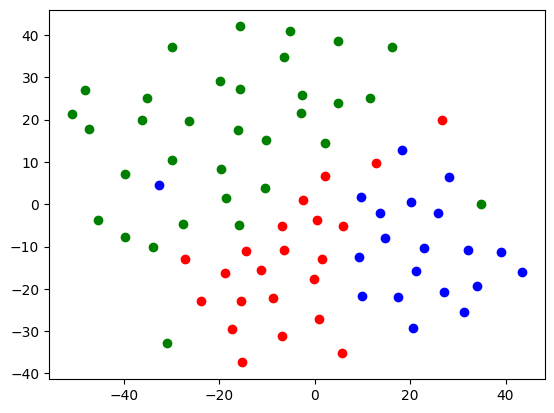

In [13]:
x = vis_dims[:,0]
y = vis_dims[:,1]

for k in range(n_clusters):
    xs = np.array(x)[df.cluster == k]
    ys = np.array(y)[df.cluster == k]

    plt.scatter(xs, ys, color=['red','blue','green','orange','black'][k])

Utilizo <b> Chat-Completion </b> para determinar que tienen en común cada cluster y generar un breve resumen. <b> GPT turbo vale el 10% de Davinci </b>

In [14]:
output = ""

for k in range(n_clusters):

    if k != 0: time.sleep(35) 
    cluster_sentences = df[df['cluster'] == k]['text'].str.cat(sep = '.')

    response = openai.ChatCompletion.create(

        model = "gpt-3.5-turbo",
        messages = [
            {'role': 'user', 'content': f'Resumir brevemente el siguiente texto : \n\n"""\n{ cluster_sentences }\n"""\n\n'}
        ],
        temperature = 0,
        max_tokens = 300,
        top_p = 1,
        frequency_penalty = 0.5,
        presence_penalty = 0,
    )

    summary = response['choices'][0]['message']['content'].replace('.','.\n')

    response = openai.ChatCompletion.create(

        model = "gpt-3.5-turbo",
        messages = [
            {'role': 'user', 'content': f'Dar un título para el siguiente texto : \n\n"""\n{ summary }\n"""\n\n'}
        ],
        temperature = 0,
        max_tokens = 100,
        top_p = 1,
        frequency_penalty = 0,
        presence_penalty = 0,
    )

    title = response['choices'][0]['message']['content']
    output += "Titulo de la sección: " + title + "\n\n " + summary + "\n"

    print(red("Seccion ") + str(k) + " : " + green(title) + "\n\n " + summary + "\n")


 Seccion 0 :  "La inteligencia artificial: ¿un peligro o una oportunidad para la humanidad?"

 El texto habla sobre la definición de inteligencia artificial y cómo las computadoras pueden replicar el comportamiento humano.
 Se mencionan los factores que hacen que las computadoras sean poderosas e inteligentes, como el poder de cómputo, la memoria y los programas de inteligencia artificial.
 También se plantea el debate sobre si la inteligencia artificial puede ser peligrosa y tomar conciencia como en las películas de ciencia ficción.
 A pesar de esto, se destacan los beneficios que esta tecnología puede traer para la salud y calidad de vida.


 Seccion 1 :  "La inteligencia artificial en la medicina: una herramienta complementaria para los médicos del futuro"

 El autor es un investigador en inteligencia artificial aplicada a medicina.
 Junto con un grupo de neurólogos informáticos, han creado un sistema de inteligencia artificial que revisa historias clínicas para validar diagnósticos

Genero un código HTML usando <b> ChatCompletion </b> que utilice la información generada en el resúmen.

In [16]:
response = openai.ChatCompletion.create(

    model = "gpt-3.5-turbo",
    messages = [
        {'role': 'system', 'content': 'Eres un programador web que realiza paǵinas con mucho estilo, colores, y diseños.'},
        {'role': 'user', 'content': f'Dar el código HTML para un página que contenga la siguiente información, utilizar estilos, colores y resaltar el título de cada sección. Además, crear un título general que resuma todo el contenido en una sóla oracion. Información a utilizar: \n\n"""\n{ output }\n"""\n\n'}
    ],
    temperature = 0.8,
    top_p = 1,
    frequency_penalty = 0,
    presence_penalty = 0,
)

response_message = response['choices'][0]['message']['content']
print(response_message)

<!DOCTYPE html>
<html>
<head>
	<title>La inteligencia artificial: ¿un peligro o una oportunidad para la humanidad?</title>
	<style>
		body{
			background-color: #e6e6e6;
			padding: 20px;
			font-family: Arial, sans-serif;
		}

		h1{
			text-align: center;
			font-size: 40px;
			color: #333;
			margin-bottom: 50px;
		}

		h2{
			color: #008080;
			font-size: 24px;
			margin-top: 50px;
			margin-bottom: 20px;
		}

		p{
			line-height: 1.5;
			font-size: 20px;
		}

		section{
			border: 2px solid #008080;
			padding: 30px;
			margin-bottom: 50px;
		}

	</style>
</head>
<body>
	<h1>La inteligencia artificial: ¿un peligro o una oportunidad para la humanidad?</h1>
	<section>
		<h2>Definición de inteligencia artificial</h2>
		<p>El texto habla sobre la definición de inteligencia artificial y cómo las computadoras pueden replicar el comportamiento humano.</p>
		<p>Se mencionan los factores que hacen que las computadoras sean poderosas e inteligentes, como el poder de cómputo, la memoria y los

Sólo tomo el código HTML, por si las dudas escribe algo por fuera de esto. Luego, genero el archivo .html

In [17]:
start_index = response_message.find("<!DOCTYPE html>")
end_index = response_message.find("</html>")

html_code = response_message[start_index: end_index + 7]

file_html = open("demo.html", "w")
file_html.write(html_code)
file_html.close()